In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from tqdm import tqdm
from src.tools import load_dataset
import numpy as np
# import wandb
from src.model import SongUNet

from typing import Optional, Tuple
import torch.nn.functional as F

In [2]:
inner_iters = 10000
batch_size = 128
vocab_size = 256
T = 10

IMG_SIZE = 32
IMG_CHANNELS = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from src.tools import load_dataset
sampler3, test_sampler3, loader3, test_loader3 = load_dataset('MNIST-colored_3', './datasets/MNIST', img_size=IMG_SIZE, batch_size=batch_size, device=device)
sampler2, test_sampler2, loader2, test_loader2 = load_dataset('MNIST-colored_2', './datasets/MNIST', img_size=IMG_SIZE, batch_size=batch_size, device=device)
Y_sampler = sampler2
X_sampler = sampler3

@torch.no_grad()
def sampler_0_model(x, batch_size: int = 200, device: str = "cpu") -> Tensor:
    x_t = x.clone()
    t = T
    while t > 0:
        p1 = torch.softmax(model_b(x_t, torch.ones(batch_size).to(device) * t), dim=-1)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (t/(T+1))
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + u/(T+1)).sample()
        t -= 1
    
    return x_t

@torch.no_grad()
def sampler_1_model(x, batch_size: int = 200, device: str = "cpu") -> Tensor:
    x_t = x.clone()
    t = T
    while t > 0:
        p1 = torch.softmax(model_f(x_t, torch.ones(batch_size).to(device) * t), dim=-1)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (t/(T+1))
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + u/(T+1)).sample()
        t -= 1
    
    return x_t  

def sampler_0(batch_size: int = 200, device: str = "cpu") -> Tensor:
    x_end = X_sampler.sample(batch_size)
    x_end = x_end.mul(0.5).add(0.5).clip(0,1)*(vocab_size-1)
    return x_end.long()

def sampler_1(batch_size: int = 200, device: str = "cpu") -> Tensor:
    x_end = Y_sampler.sample(batch_size)
    x_end = x_end.mul(0.5).add(0.5).clip(0,1)*(vocab_size-1)
    return x_end.long()

In [4]:
# x_0 = sampler_0(10)
# x_1 = sampler_1(10)

In [5]:
# x_0_model = sampler_0_model(x_1, 10, device)
# x_1_model = sampler_1_model(x_0, 10, device)

In [6]:
# plt.imshow(x_1_model.permute(0,2,3,1)[0].detach().cpu())

# Training

In [7]:
model_f = SongUNet(img_resolution=32, in_channels=3, out_channels=3, vocab_size=vocab_size, model_channels=96).to(device)
optim_f = torch.optim.Adam(model_f.parameters(), lr=1e-3)

model_b = SongUNet(img_resolution=32, in_channels=3, out_channels=3, vocab_size=vocab_size, model_channels=96).to(device)
optim_b = torch.optim.Adam(model_b.parameters(), lr=1e-3)

print('denoiser params:', np.sum([np.prod(p.shape) for p in model_f.parameters()]))

denoiser params: 35445888


In [10]:
model_f = torch.load('model_f.pt',weights_only=False)
model_b = torch.load('model_b.pt',weights_only=False)

In [11]:
def train_with_model(model, optim, type='f'):
    loss_sum = 0
    for i in tqdm(range(1000)):
        t = torch.randint(low=1, high=T + 2, size=(batch_size,), device=device)

        if type=='f':
            x_1 = sampler_1(batch_size)
            x_0 = sampler_0_model(x_1, batch_size, device).view(batch_size, -1)
            x_1 = x_1.view(batch_size, -1)
            x_t = torch.where(torch.randint(low=1, high=T + 2, size=(batch_size, model.d), device=device) <  t[:, None], x_0, x_1)
        else:
            x_0 = sampler_0(batch_size)
            x_1 = sampler_1_model(x_0, batch_size, device).view(batch_size, -1)
            x_0 = x_0.view(batch_size, -1)
            x_t = torch.where(torch.randint(low=1, high=T + 2, size=(batch_size, model.d), device=device) <  t[:, None], x_1, x_0)

        x_t = x_t.view(x_1.shape[0], IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
        logits = model(x_t, t).flatten(start_dim=0, end_dim=-2)
        if type=='f':
            loss = F.cross_entropy(logits, x_1.flatten(start_dim=0, end_dim=-1)).mean()
        else:
            loss = F.cross_entropy(logits, x_0.flatten(start_dim=0, end_dim=-1)).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_sum += loss.item()

    print('Loss:', loss_sum/1000)

In [12]:
# def train_with_data(model, optim, type='f'):
#     # for iter in tqdm(range(inner_iters)):
#     for iter in range(inner_iters):
#         loss_sum = 0
#         for i in range(100):
#             t = torch.randint(low=1, high=T + 2, size=(batch_size,), device=device)
#             x_0 = sampler_0(batch_size).view(batch_size, -1)
#             x_1 = sampler_1(batch_size).view(batch_size, -1)
            
#             if type=='f':
#                 x_t = torch.where(torch.randint(low=1, high=T + 2, size=(batch_size, model.d), device=device) <  t[:, None], x_0, x_1)
#             else:
#                 x_t = torch.where(torch.randint(low=1, high=T + 2, size=(batch_size, model.d), device=device) <  t[:, None], x_1, x_0)

#             x_t = x_t.view(x_1.shape[0], IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
#             logits = model(x_t, t).flatten(start_dim=0, end_dim=-2)
#             if type=='f':
#                 loss = F.cross_entropy(logits, x_1.flatten(start_dim=0, end_dim=-1)).mean()
#             else:
#                 loss = F.cross_entropy(logits, x_0.flatten(start_dim=0, end_dim=-1)).mean()

#             optim.zero_grad()
#             loss.backward()
#             optim.step()
#             loss_sum += loss.item()

#         print('Loss:', loss_sum/100)
#         visualize(sampler_0, model_f, f'samples/f/{iter}.png')
#         # visualize(sampler_1, model_b, f'samples/f/{iter}.png')

#         # torch.save(model, 'model_f.pt')

# Sampling

In [13]:
def cost(results):
    costs = 0
    for i in range(len(results)-1):
        costs += (results[i][0] != results[i+1][0]).float().mean()
    
    return costs

In [16]:
def visualize(sampler, model, name='samples/test.png'):
    N = 100

    x_t = sampler(N)
    x_0 = x_t
    t = T+1
    results = [(x_t, t)]
    while t > 0:
        p1 = torch.softmax(model(x_t, torch.ones(N).to(device) * t), dim=-1)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (t/(T+1))
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + u/(T+1)).sample()
        t -= 1
        results.append((x_t.long(), t))

    x_1 = results[-1][0]

    fig, axes = plt.subplots(1, len(results), figsize=(15, 3), sharex=True, sharey=True)

    for i, (x_t, t) in enumerate(results):
        axes[i].imshow(x_t.permute(0,2,3,1)[0].detach().cpu())

    plt.tight_layout()
    # plt.savefig(name)  # Saves as PNG
    # plt.close()
    plt.show()
    print('OT cost:', cost(results))

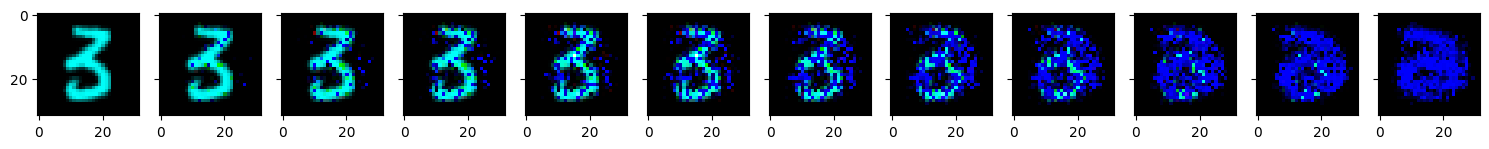

OT cost: tensor(0.6210, device='cuda:0')


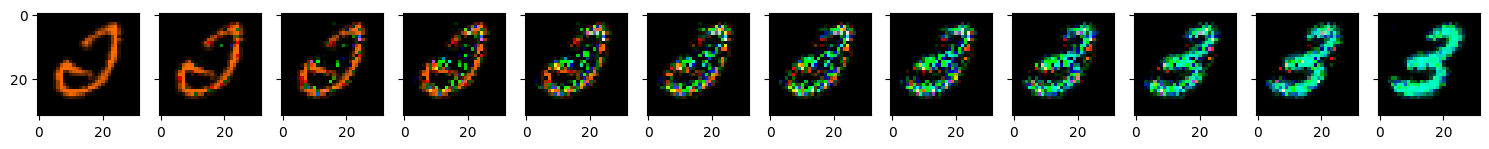

OT cost: tensor(0.6461, device='cuda:0')


In [17]:
visualize(sampler_0, model_f, f'samples/f/ipf/{0}.png')
visualize(sampler_1, model_b, f'samples/f/ipf/{0}.png')

100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


Loss: 0.690387346148491


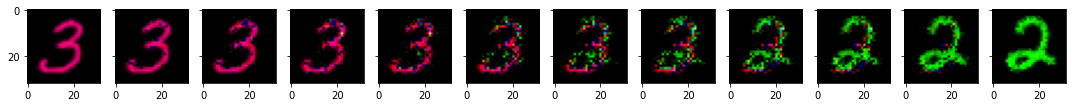

OT cost: tensor(0.6322, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


Loss: 0.5785286319255829


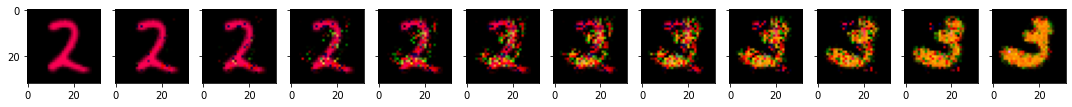

OT cost: tensor(0.6810, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


Loss: 0.6927365106344223


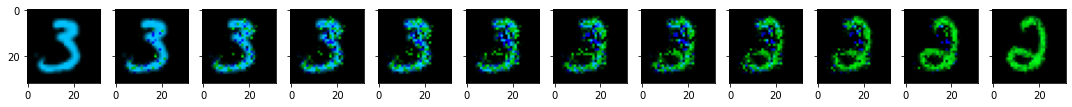

OT cost: tensor(0.6174, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


Loss: 0.5798199957609177


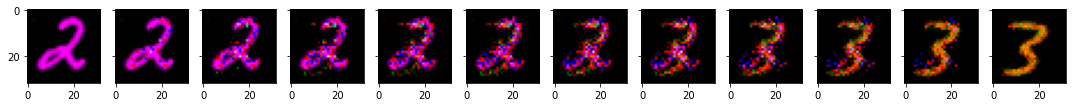

OT cost: tensor(0.6816, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


Loss: 0.6933583968877792


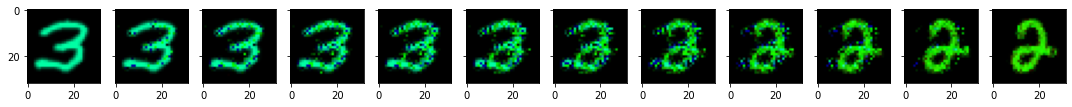

OT cost: tensor(0.6284, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


Loss: 0.5769880717992782


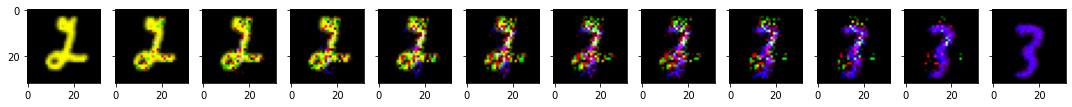

OT cost: tensor(0.6819, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


Loss: 0.6948811614513397


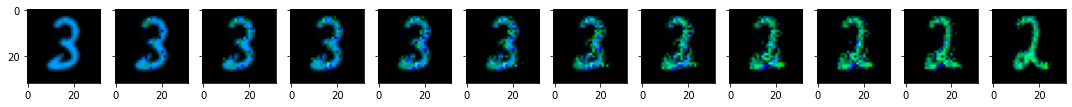

OT cost: tensor(0.6057, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


Loss: 0.5787941944599152


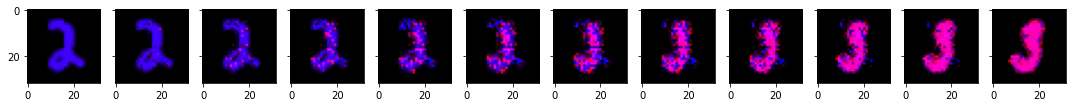

OT cost: tensor(0.6717, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


Loss: 0.6973011022806168


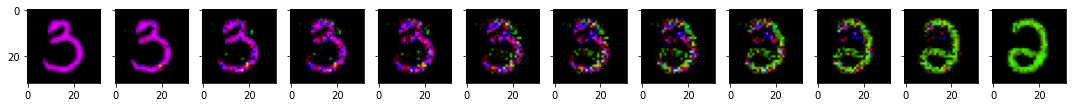

OT cost: tensor(0.6149, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


Loss: 0.5804551303386688


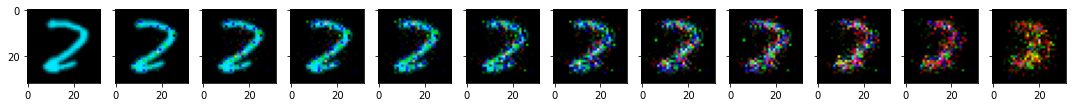

OT cost: tensor(0.6593, device='cuda:0')


100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


Loss: 0.697689248919487


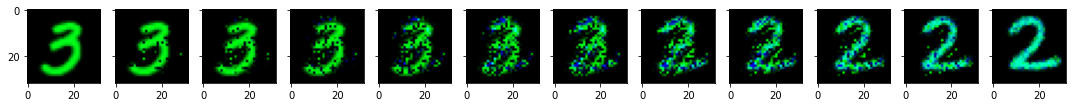

OT cost: tensor(0.6057, device='cuda:0')


  5%|▌         | 5/100 [00:10<03:12,  2.03s/it]

In [ ]:
for i in range(10):
    train_with_model(model_f, optim_f, 'f')
    visualize(sampler_0, model_f, f'samples/f/ipf/{iter}.png')
    torch.save(model_f, f'model_f_{i}.pt')
    train_with_model(model_b, optim_b, 'b')
    visualize(sampler_1, model_b, f'samples/b/ipf/{iter}.png')
    torch.save(model_b, f'model_b_{i}.pt')